# Domain LLMs

# 1. Fine tuning a custom model

Using Gemini API to fine-tune a custom, task-specific model. Example here is fine-tuning a model to classify the a piece of text (a newsgroun post) to its corresponding category (the news group name)

[AI Studio](https://aistudio.google.com/app/tune) also supports creating new tuned models directly in the web UI, allowing a quick creation of and monitoring of models using data from Google Sheets, Drive or own files.

## Setup

In [1]:
import google.generativeai as genai
from env import *

%load_ext autoreload
%autoreload 2

In [2]:
GOOGLE_API_KEY = GOOGLE_API_KEY
genai.configure(api_key=GOOGLE_API_KEY)

### Explore available models

[`TunedModel.create`](https://ai.google.dev/api/tuning#method:-tunedmodels.create) API method allows for fine-tuning job to create a custom model. 

More information on [the model tuning docs](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?lang=python).

In [3]:
for model in genai.list_models():
    if "createTunedModel" in model.supported_generation_methods:
        print(model.name)

models/gemini-1.0-pro-001
models/gemini-1.5-flash-001-tuning


## Download the dataset

As with 'Classifying embeddings with Keras and the Gemini API' exercise from the Embedding part, newsgroups dataset is used to train the model, this time with a fine-tuned Gemini model. 

In [20]:
!pip install scikit-learn
! pip install pandas
! pip install tqdm

In [8]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset="train")
newsgroups_test = fetch_20newsgroups(subset="test")

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
print(newsgroups_train.data[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Prepare the dataset

Same pre-proccessing as the previous exercise. 
- Removes personal information,
- Removes mail headers make the text appear more like regular text, avoiding the model to be over-depend on specific fields.

In [12]:
import email
import re

import pandas as pd


def preprocess_newsgroup_row(data):
    # Extract only the subject and body
    msg = email.message_from_string(data)
    text = f"{msg['Subject']}\n\n{msg.get_payload()}"
    # Strip any remaining email addresses
    text = re.sub(r"[\w\.-]+@[\w\.-]+", "", text)
    # Truncate the text to fit within the input limits
    text = text[:40000]

    return text


def preprocess_newsgroup_data(newsgroup_dataset):
    # Put data points into dataframe
    df = pd.DataFrame(
        {"Text": newsgroup_dataset.data, "Label": newsgroup_dataset.target}
    )
    # Clean up the text
    df["Text"] = df["Text"].apply(preprocess_newsgroup_row)
    # Match label to target name index
    df["Class Name"] = df["Label"].map(lambda l: newsgroup_dataset.target_names[l])

    return df

In [13]:
# Apply preprocessing to training and test datasets
df_train = preprocess_newsgroup_data(newsgroups_train)
df_test = preprocess_newsgroup_data(newsgroups_test)

df_train.head()

,Text,Label,Class Name
0,WHAT car is this!?\n\n I was wondering if anyo...,7,rec.autos
1,SI Clock Poll - Final Call\n\nA fair number of...,4,comp.sys.mac.hardware
2,"PB questions...\n\nwell folks, my mac plus fin...",4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\n\nRobert J.C. Kyanko () wr...,1,comp.graphics
4,Re: Shuttle Launch Question\n\nFrom article <>...,14,sci.space


Now sample the data. Keeping 50 rows for each category for training. Note that this is even fewer than the Keras example, as this technique (parameter-efficient fine-tuning, or PEFT) updates a relatively small number of parameters and does not require training a new model or updating the large model.

In [14]:
def sample_data(df, num_samples, classes_to_keep):
    # Sample rows, selecting num_samples of each Label.
    df = (
        df.groupby("Label")[df.columns]
        .apply(lambda x: x.sample(num_samples))
        .reset_index(drop=True)
    )

    df = df[df["Class Name"].str.contains(classes_to_keep)]
    df["Class Name"] = df["Class Name"].astype("category")

    return df


TRAIN_NUM_SAMPLES = 50
TEST_NUM_SAMPLES = 10
# Keep rec.* and sci.*
CLASSES_TO_KEEP = "^rec|^sci"

df_train = sample_data(df_train, TRAIN_NUM_SAMPLES, CLASSES_TO_KEEP)
df_test = sample_data(df_test, TEST_NUM_SAMPLES, CLASSES_TO_KEEP)

## Evaluate baseline performance

it's good practice to perform an evaluatio before start tuning a model, to compare difference after tuning.

First identify a single sample row to use for visual inspection.

In [15]:
sample_idx = 0
sample_row = preprocess_newsgroup_row(newsgroups_test.data[sample_idx])
sample_label = newsgroups_test.target_names[newsgroups_test.target[sample_idx]]

print(sample_row)
print('---')
print('Label:', sample_label)

Need info on 88-89 Bonneville


 I am a little confused on all of the models of the 88-89 bonnevilles.
I have heard of the LE SE LSE SSE SSEI. Could someone tell me the
differences are far as features or performance. I am also curious to
know what the book value is for prefereably the 89 model. And how much
less than book value can you usually get them for. In other words how
much are they in demand this time of year. I have heard that the mid-spring
early summer is the best time to buy.

			Neil Gandler

---
Label: rec.autos


Passing the text directly in as a prompt does not yield the desired results. The model will attempt to respond to the message.

In [16]:
baseline_model = genai.GenerativeModel("gemini-1.5-flash-001")
response = baseline_model.generate_content(sample_row)
print(response.text)

You're right to be confused! The 1988-1989 Pontiac Bonnevilles had a dizzying array of trim levels, each with its own unique features and performance characteristics. Here's a breakdown:

**1988-1989 Bonneville Trim Levels**

* **Base:** The most basic model, featuring a 3.8L V6 engine, cloth upholstery, and minimal features.
* **LE:** The "Luxury Edition" offered a more upscale interior with plusher seating, woodgrain accents, and power accessories. It still came with the 3.8L V6.
* **SE:** The "Sport Edition" offered a more performance-oriented feel with sportier styling, a 5.0L V8 engine, and a slightly firmer suspension.
* **LSE:**  A blend of luxury and sport, the "Luxury Sport Edition" combined the SE's V8 with the LE's plush interior and features.
* **SSE:** The "Sport Sedan Edition" was the top-of-the-line performance model, featuring a 3.8L Turbocharged V6 engine, a unique body kit, and performance suspension tuning.
* **SSEi:**  "Sport Sedan Edition, Injected"  This trim leve

The idea is to use the prompt engineering techniques to induce the model to perform the desired task.

In [17]:
# Ask the model directly in a zero-shot prompt.

prompt = "From what newsgroup does the following message originate?"
baseline_response = baseline_model.generate_content([prompt, sample_row])
print(baseline_response.text)

This message most likely originates from a **Buick-specific newsgroup**, such as:

* **alt.autos.buick**
* **rec.autos.buick**

These newsgroups would be frequented by Buick enthusiasts and owners, making it the ideal place to ask for information about specific models like the 1988-1989 Bonneville. 



That technique produces quite a verbose response. Refining prompt further.

In [18]:
from google.api_core import retry

# You can use a system instruction to do more direct prompting, and get a
# more succinct answer.

system_instruct = """
You are a classification service. You will be passed input that represents
a newsgroup post and you must respond with the newsgroup from which the post
originates.
"""

instructed_model = genai.GenerativeModel("gemini-1.5-flash-001",
                                         system_instruction=system_instruct)

retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

# If you want to evaluate your own technique, replace this function with your
# model, prompt and other code and return the predicted answer.
def predict_label(post: str) -> str:
    response = instructed_model.generate_content(post, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        # Clean up the response.
        return response.text.strip()


prediction = predict_label(sample_row)

print(prediction)
print()
print("Correct!" if prediction == sample_label else "Incorrect.")

rec.autos.misc

Incorrect.


Now run a short evaluation using the function defined above. The test set is further sampled to ensure the experiment runs smoothly on the API's free tier. In practice the evaluation should be donw of the whole data set.

In [24]:
from tqdm.rich import tqdm

tqdm.pandas()


# Further sample the test data to be mindful of the free-tier quota.
df_baseline_eval = sample_data(df_test, 2, '.*')

# Make predictions using the sampled data.
df_baseline_eval['Prediction'] = df_baseline_eval['Text'].progress_apply(predict_label)

# And calculate the accuracy.
accuracy = (df_baseline_eval["Class Name"] == df_baseline_eval["Prediction"]).sum() / len(df_baseline_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/home/kwonowk/code/kwonowk/Projects/google-gen-ai-course/.venv/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 25.00%


Now take a look at the dataframe to compare the predictions with the labels.

In [25]:
df_baseline_eval

,Text,Label,Class Name,Prediction
0,Manual Xmission-Advice needed...\n\nI have man...,7,rec.autos,rec.autos.tech
1,"Lexus and Infiniti\n\nFirst off, the correct s...",7,rec.autos,rec.autos.misc
2,"Re: Type spesifications (CB, VFR, GT, etc.)\n\...",8,rec.motorcycles,rec.motorcycles
3,Volvo Attack!\n\nI was privelged enough to exp...,8,rec.motorcycles,rec.motorcycles
4,"I am right! No, *I* am right! (was Re: BOB K...",9,rec.sport.baseball,rec.sports.baseball
5,The Babe v. The Pride of the Yankees\n\n\nThe ...,9,rec.sport.baseball,rec.movies.reviews
6,Re: Trivia question\n\n The goalie to whom yo...,10,rec.sport.hockey,rec.sport.hockey
7,Re: Pens fans reactions\n\n\n>I'm really impre...,10,rec.sport.hockey,rec.sports.hockey
8,Re: Why the clipper algorithm is secret\n\nIn ...,11,sci.crypt,(error)
9,"Re: Screw the people, crypto is for hard-core ...",11,sci.crypt,(error)


## Tune a custom model

In this part of the example, a model is created by tuning, without the need for prompting or system instructions.

The data contains both input text (the processed posts) and output text (the category, or newsgroup), which can be used to start tuning a model.

The Gemini Python SDK for tuning supports Pandas dataframes as input, so there is no need for any custom data generators or pipelines. Just specifying the input and the relevant columns as the `input_key` and `output_key` suffice.

Below model hyperparameters can be specified when calling `create_tuned_model`:
 - `epoch_count`: defines how many times to loop through the data,
 - `batch_size`: defines how many rows to process in a single step, and
 - `learning_rate`: defines the scaling factor for updating model weights at each step.

Omitting them result in using default values. [Learn more](https://developers.google.com/machine-learning/crash-course/linear-regression/hyperparameters) For this example these parameters were selected by running some tuning jobs and selecting parameters that were both effective and quick.

In [26]:
from collections.abc import Iterable
import random


# Append a random number to the model ID so you can re-run with a higher chance
# of creating a unique model ID.
model_id = f"newsgroup-classifier-{random.randint(10000, 99999)}"

# Upload the training data and queue the tuning job.
tuning_op = genai.create_tuned_model(
    "models/gemini-1.5-flash-001-tuning",
    training_data=df_train,
    input_key="Text",  # the column to use as input
    output_key="Class Name",  # the column to use as output
    id=model_id,
    display_name="Newsgroup classification model",
    batch_size=16,
    epoch_count=2,
)

print(model_id)

newsgroup-classifier-93005


This has created a tuning job that will run in the background. To inspect the progress of the tuning job, run this cell to plot the current status and loss curve. Once the status reaches `ACTIVE`, tuning is complete and the model is ready to use.

Tuning jobs are queued, so it may look like no training steps have been taken initially but it will progress. Tuning can take upwards of 20 minutes, depending on factors like your dataset size and how busy the tuning infrastrature is.

It is safe to stop this cell at any point. It will not stop the tuning job.

State.CREATING
State.CREATING
State.CREATING
State.CREATING
Done! The model is ACTIVE


<Axes: xlabel='step', ylabel='mean_loss'>

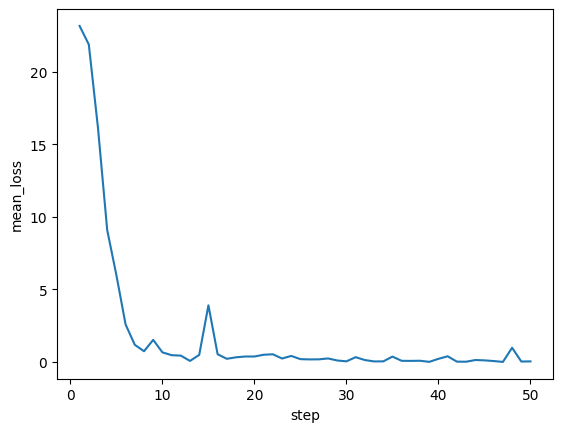

In [29]:
import time
import seaborn as sns


while (tuned_model := genai.get_tuned_model(f"tunedModels/{model_id}")).state.name != 'ACTIVE':

    print(tuned_model.state)
    time.sleep(60)

print(f"Done! The model is {tuned_model.state.name}")

# Plot the loss curve.
snapshots = pd.DataFrame(tuned_model.tuning_task.snapshots)
sns.lineplot(data=snapshots, x="step", y="mean_loss")


Note that the `seaborn` module may output warnings containing `FutureWarning: use_inf_as_na option is deprecated`. These are expected and can be ignored.

## Use the new model

Now a model is tuned, applying the model with custom data. Calling a model is specified using the `tunedModels/` prefix.

In [30]:
your_model = genai.GenerativeModel(f"tunedModels/{model_id}")

new_text = """
First-timer looking to get out of here.

Hi, I'm writing about my interest in travelling to the outer limits!

What kind of craft can I buy? What is easiest to access from this 3rd rock?

Let me know how to do that please.
"""

response = your_model.generate_content(new_text)
print(response.text)

sci.space


### Evaluation

Model outputs labels that correspond to those in the training data, and without any system instructions or prompting, which is already a great improvement. Then evaluating its performance on the test set.

Note that there is no parallelism in this example; classifying the test sub-set will take a few minutes.

In [31]:
def classify_text(text: str) -> str:
    """Classify the provided text into a known newsgroup."""
    response = your_model.generate_content(text, request_options=retry_policy)
    rc = response.candidates[0]

    # Any errors, filters, recitation, etc we can mark as a general error
    if rc.finish_reason.name != "STOP":
        return "(error)"
    else:
        return rc.content.parts[0].text


# The sampling here is just to minimise your quota usage. If you can, you should
# evaluate the whole test set with `df_model_eval = df_test.copy()`.
df_model_eval = sample_data(df_test, 4, '.*')


df_model_eval["Prediction"] = df_model_eval["Text"].progress_apply(classify_text)

accuracy = (df_model_eval["Class Name"] == df_model_eval["Prediction"]).sum() / len(df_model_eval)
print(f"Accuracy: {accuracy:.2%}")

Output()

/home/kwonowk/code/kwonowk/Projects/google-gen-ai-course/.venv/lib/python3.10/site-packages/tqdm/std.py:885: TqdmExperimentalWarning: rich is experimental/alpha
  t = cls(total=total, **tqdm_kwargs)


Accuracy: 90.62%


Note that the accuracy from Gemini fine-tuned model is actually lower than deep learning technique (0.930).

## Compare token usage

AI Studio and the Gemini API provide model tuning at no cost, however normal limits and charges apply for *use* of a tuned model.

The size of the input prompt and other generation config like system instructions, as well as the number of generated output tokens, all contribute to the overall cost of a request.

In [32]:
# Calculate the *input* cost of the baseline model with system instructions.
sysint_tokens = instructed_model.count_tokens(sample_row).total_tokens
print(f'System instructed baseline model: {sysint_tokens} (input)')

# Calculate the input cost of the tuned model.
tuned_tokens = your_model.count_tokens(sample_row).total_tokens
print(f'Tuned model: {tuned_tokens} (input)')

savings = (sysint_tokens - tuned_tokens) / tuned_tokens
print(f'Token savings: {savings:.2%}')  # Note that this is only n=1.

System instructed baseline model: 171 (input)
Tuned model: 135 (input)
Token savings: 26.67%


The earlier verbose model also produced more output tokens than needed for this task.

In [33]:
baseline_token_output = baseline_response.usage_metadata.candidates_token_count
print('Baseline (verbose) output tokens:', baseline_token_output)

tuned_model_output = your_model.generate_content(sample_row)
tuned_tokens_output = tuned_model_output.usage_metadata.candidates_token_count
print('Tuned output tokens:', tuned_tokens_output)

Baseline (verbose) output tokens: 77
Tuned output tokens: 4


## Next steps

And check out the [fine-tuning tutorial](https://ai.google.dev/gemini-api/docs/model-tuning/tutorial?hl=en&lang=python) for another example that shows a tuned model extending beyond the training data to new, unseen inputs.